In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error, log_loss, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler


#Generating non-linear data

In [55]:
data, labels = make_circles(n_samples=1000, random_state=0, noise=0.2, factor=0.3)
print(data.shape, labels.shape)

(1000, 2) (1000,)


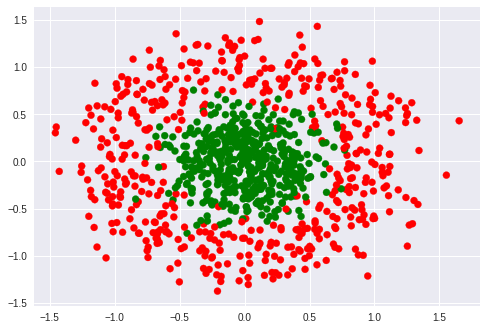

In [56]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [57]:
#Make train test split
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, Y_train.shape)

(750, 2) (750,)


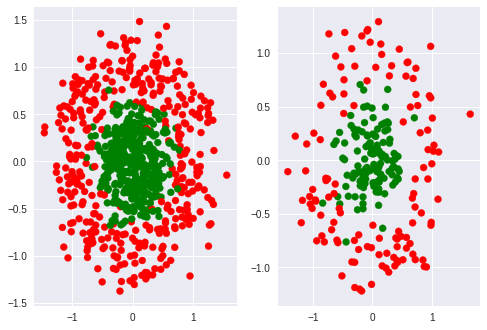

In [58]:
#Checking is both the test and train split resembles the original distribution
ax = plt.subplot(1,2,1)
ax.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap=my_cmap)
ax = plt.subplot(1,2,2)
ax.scatter(X_test[:,0], X_test[:,1], c=Y_test, cmap=my_cmap)

In [59]:
#Standardizing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
np.std(X_train_scaled[:,1])

1.0

#Modelling data using Sigmoid Neuron

In [0]:
class SigmoidNeuron:
    def __init__(self):
        self.w = None
        self.b = None
    
    def perceptron(self, x):
        return(np.dot(self.w, x)+self.b)
    
    def sigmoid(self, x):
        return(1.0/(1.0 + np.exp(-x)))
    
    def grad_w_mse(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        return((y_pred - y) * y_pred * (1 - y_pred) * x)
    
    def grad_b_mse(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        return((y_pred - y) * y_pred * (1 - y_pred))
    
    def grad_w_ce(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        return((y_pred-y)*x)
    
    def grad_b_ce(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        return(y_pred - y)
    
    def fit(self, X, Y, epochs=1, learning_rate=1, initialize=True, display_loss=False, loss_fn='mse'):
        if(initialize):
            self.w = np.random.randn(1,X.shape[1])
            self.b = 0
        
        min_loss=0
        if(display_loss):
            loss={}
        for epoch in tqdm_notebook(range(epochs), total=epochs, unit='epoch'):
            dw=0
            db=0
            for x, y in zip(X,Y):
                if(loss_fn=='mse'):
                    dw += self.grad_w_mse(x,y)
                    db += self.grad_b_mse(x,y)
                if(loss_fn=='ce'):
                    dw += self.grad_w_ce(x,y)
                    db += self.grad_b_ce(x,y)
            
            Y_pred = self.predict(X)
            if(loss_fn=='mse'):
                loss[epoch] = mean_squared_error(Y, Y_pred)
            if(loss_fn=='ce'):
                loss[epoch] = log_loss(Y, Y_pred)
            if(epoch==1):
                min_loss = loss[epoch]
            if(loss[epoch] < min_loss):
                min_loss = loss[epoch]
                chkpt_w = self.w
                chkpt_b = self.b
            m = X.shape[0]
            self.w -= learning_rate * dw/m
            self.b -= learning_rate * db/m
            
        if(display_loss):
            plt.plot(loss.values())
            if(loss_fn=='mse'):
                plt.ylabel('Mean Squared Loss')
            if(loss_fn=='ce'):
                plt.ylabel('Log Loss')
            plt.xlabel('epochs')
            plt.show()
        self.w = chkpt_w
        self.b = chkpt_b
        print("min_loss: ",min_loss)
        return(self.w, self.b)
        
    def predict(self, X):
        Y_pred = []
        for x in X:
            Y_pred.append(self.sigmoid(self.perceptron(x)))
        return(np.array(Y_pred))

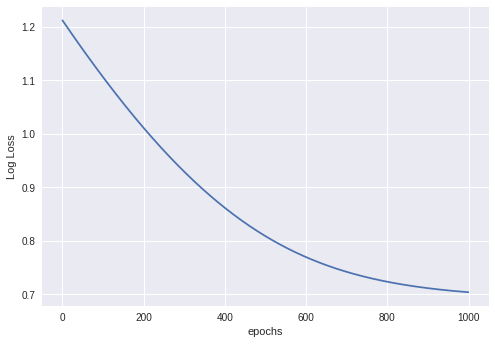

min_loss:  0.7040740132733613


In [61]:
sn = SigmoidNeuron()
w, b = sn.fit(X_train_scaled, Y_train, epochs=1000, loss_fn='ce', learning_rate=0.01, display_loss=True)

In [63]:
Y_train_pred = sn.predict(X_train_scaled)
Y_train_pred_binarized = np.array(Y_train_pred>0.5).astype('int').ravel()
Y_test_pred = sn.predict(X_test_scaled)
Y_test_pred_binarized = np.array(Y_test_pred>0.5).astype('int').ravel()
train_accuracy = accuracy_score(Y_train, Y_train_pred_binarized)
test_accuracy  = accuracy_score(Y_test, Y_test_pred_binarized)
print("train_accuracy: ", train_accuracy)
print("test_accuracy: ", test_accuracy)

train_accuracy:  0.48933333333333334
test_accuracy:  0.492


Text(0.5, 1.0, 'Test data')

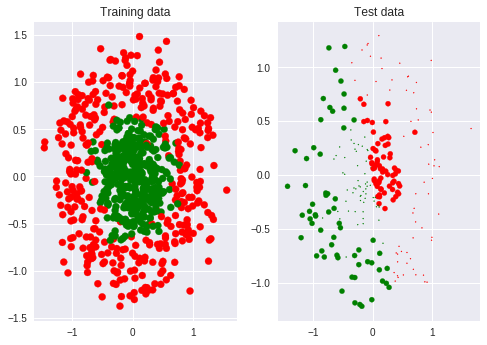

In [64]:
#Visualize what the model learnt
ax = plt.subplot(1,2,1)
ax.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap=my_cmap)
plt.title('Training data')

ax = plt.subplot(1,2,2)
ax.scatter(X_test[:,0], X_test[:,1], c=Y_test_pred_binarized, cmap=my_cmap, s=25*np.abs(Y_test_pred_binarized - Y_test) + 1)
plt.title('Test data')

#Modelling data with a neural network

In [0]:
class FFNeuralNet:
  
  '''This is a class for feedforward Nnet'''
  
  def __init__(self, n_inputs, n_outputs, hidden_sizes=[2]):
    self.nx = n_inputs
    self.ny = n_outputs
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny]
    
    self.W = {}
    self.B = {}
    
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i]))
    
  def sigmoid(self, x):
    return(1.0/(1.0 + np.exp(-x)))
  
  def feedforward(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)
    
    for i in range(self.nh+1):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    
    return(self.H[self.nh+1])
  
  def grad_sigmoid(self, x):
    return(x * (1-x))
  
  def grad(self, x, y):
    self.feedforward(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1]= np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1]))

  def fit(self, X, Y, epochs=1, learning_rate=1, display_loss=False, initialize=True):
    
    if(initialize):
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))
    
    if(display_loss):
      loss={}
      
    for epoch in tqdm_notebook(range(epochs), total=epochs, unit='epoch'):
      dW = {}
      dB = {}
      for i in range(self.nh+1): 
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))
      for x,y in zip(X,Y):
        self.grad(x,y)
       
        for i in range(self.nh+1):
          dW[i+1] += self.dW[i+1]
          dB[i+1] += self.dB[i+1]
      
      m = X.shape[1]
      for i in range(self.nh+1):
        self.W[i+1] -= learning_rate * dW[i+1]/m
        self.B[i+1] -= learning_rate * dB[i+1]/m
      
      if(display_loss):
        Y_pred = self.predict(X)
        loss[epoch] = mean_squared_error(Y, Y_pred)
     
    if(display_loss):
      plt.plot(loss.values())
      plt.xlabel('epochs')
      plt.ylabel('MSE')
      plt.show()

  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.feedforward(x)
      Y_pred.append(y_pred)
    return(np.array(Y_pred).squeeze())  
    
      

In [0]:
ffnn = FFNeuralNet(2, 1, [2])

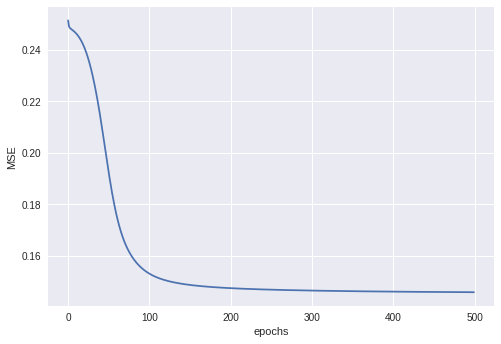

In [67]:
ffnn.fit(X_train_scaled, Y_train, epochs=500, learning_rate=0.01, display_loss=True)

In [68]:
Y_train_pred = ffnn.predict(X_train_scaled)
Y_train_pred_binarized = np.array(Y_train_pred>0.5).astype('int').ravel()
Y_test_pred = ffnn.predict(X_test_scaled)
Y_test_pred_binarized = np.array(Y_test_pred>0.5).astype('int').ravel()
train_accuracy = accuracy_score(Y_train, Y_train_pred_binarized)
test_accuracy  = accuracy_score(Y_test, Y_test_pred_binarized)
print("train_accuracy: ", train_accuracy)
print("test_accuracy: ", test_accuracy)

train_accuracy:  0.8053333333333333
test_accuracy:  0.796


Text(0.5, 1.0, 'Test data')

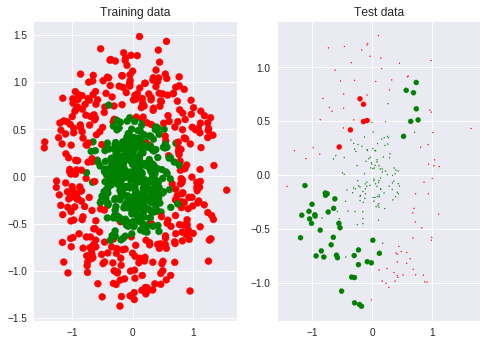

In [69]:
#Visualize what the model learnt
ax = plt.subplot(1,2,1)
ax.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap=my_cmap)
plt.title('Training data')

ax = plt.subplot(1,2,2)
ax.scatter(X_test[:,0], X_test[:,1], c=Y_test_pred_binarized, cmap=my_cmap, s=25*np.abs(Y_test_pred_binarized - Y_test) + 1)
plt.title('Test data')

# Construting a deep neural network
As the model still seems to be lagging in modelling the data with a simple single layer(2 neurons), let's build something deep. This time with 4 neurons.


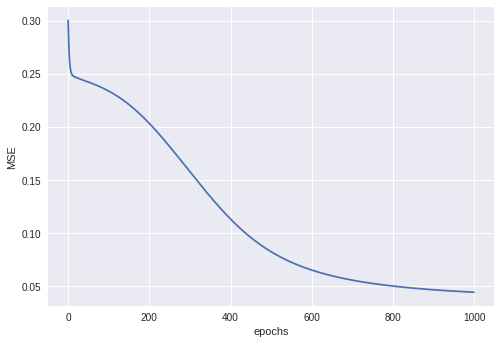

In [81]:
deep_ffnn = FFNeuralNet(2, 1, [4])
deep_ffnn.fit(X_train_scaled, Y_train, epochs=1000, learning_rate=0.001, display_loss=True)

In [82]:
Y_train_pred = deep_ffnn.predict(X_train_scaled)
Y_train_pred_binarized = np.array(Y_train_pred>0.5).astype('int').ravel()
Y_test_pred = deep_ffnn.predict(X_test_scaled)
Y_test_pred_binarized = np.array(Y_test_pred>0.5).astype('int').ravel()
train_accuracy = accuracy_score(Y_train, Y_train_pred_binarized)
test_accuracy  = accuracy_score(Y_test, Y_test_pred_binarized)
print("train_accuracy: ", train_accuracy)
print("test_accuracy: ", test_accuracy)

train_accuracy:  0.9493333333333334
test_accuracy:  0.948


Text(0.5, 1.0, 'Test data')

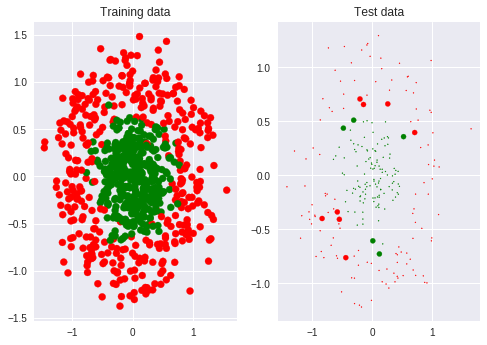

In [83]:
#Visualize what the model learnt
ax = plt.subplot(1,2,1)
ax.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap=my_cmap)
plt.title('Training data')

ax = plt.subplot(1,2,2)
ax.scatter(X_test[:,0], X_test[:,1], c=Y_test_pred_binarized, cmap=my_cmap, s=25*np.abs(Y_test_pred_binarized - Y_test) + 1)
plt.title('Test data')